In [182]:
import datetime
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import pandas as pd

import seaborn as sns

print(tf.__version__)

2.8.4


In [6]:
PROJECT = !gcloud config list --format 'value(core.project)'
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [2]:
%%bash
ls /home/jupyter/heart-failure/*.csv

/home/jupyter/heart-failure/TEST.csv
/home/jupyter/heart-failure/TRAIN.csv
/home/jupyter/heart-failure/VALIDATE.csv
/home/jupyter/heart-failure/heart.csv
/home/jupyter/heart-failure/scaled-engineered-heart.csv
/home/jupyter/heart-failure/scaled-heart-test.csv
/home/jupyter/heart-failure/scaled-heart-train.csv
/home/jupyter/heart-failure/scaled-heart-val.csv
/home/jupyter/heart-failure/scaled-heart.csv


In [163]:
%%bash
head -5 /home/jupyter/heart-failure/*.csv

==> /home/jupyter/heart-failure/TEST.csv <==
,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
925,63,F,ATA,140,195,0,Normal,179,N,0.0,Up,0
926,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
927,65,M,ASY,160,0,1,ST,122,N,1.2,Flat,1
928,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1

==> /home/jupyter/heart-failure/TRAIN.csv <==
,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,46,M,ASY,140,311,0,Normal,120,Y,1.8,Flat,1
1,62,M,ATA,120,254,0,LVH,93,Y,0.0,Flat,1
2,51,M,NAP,110,175,0,Normal,123,N,0.6,Up,0
3,62,F,TA,140,0,1,Normal,143,N,0.0,Flat,1

==> /home/jupyter/heart-failure/VALIDATE.csv <==
,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
831,51,M,ASY,140,299,0,Normal,173,Y,1.6,Up,1
832,65,M,ASY,130,275,0,ST,115,Y,1.0,Flat,1
833,36,M,NAP,112,340,0,Normal,184,N,1.0,Flat,0
834,60,M,ASY,132,218,0,ST,

In [44]:
hf_file = '/home/jupyter/heart-failure/scaled-heart.csv'

In [171]:
dtypes = {'Age':int, 'Sex':str, 'ChestPainType':str, 'RestingBP':int, 'Cholesterol':int, 'FastingBS':str,
       'RestingECG':str, 'MaxHR':int, 'ExerciseAngina':str, 'Oldpeak':float, 'ST_Slope':str,
       'HeartDisease':int, 'split':str}

In [172]:
df = pd.read_csv(hf_file,dtype=dtypes)

In [173]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,split
0,46,M,ASY,140,311,0,Normal,120,Y,1.8,Flat,1,TRAIN
1,62,M,ATA,120,254,0,LVH,93,Y,0.0,Flat,1,TRAIN
2,51,M,NAP,110,175,0,Normal,123,N,0.6,Up,0,TRAIN
3,62,F,TA,140,0,1,Normal,143,N,0.0,Flat,1,TRAIN
4,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,44,M,ATA,130,219,0,LVH,188,N,0.0,Up,0,TEST
1014,56,M,TA,120,193,0,LVH,162,N,1.9,Flat,0,TEST
1015,50,M,ASY,140,341,0,ST,125,Y,2.5,Flat,1,TEST
1016,54,M,ATA,108,309,0,Normal,156,N,0.0,Up,0,TEST


In [167]:
#split to three files to use the tf.data workflow

split = df.split.unique()

col = list(df.columns)
keep_col = col.pop(col.index('split'))



for s in split:
    df[df['split']== s][df.columns[:-1]].to_csv('/home/jupyter/heart-failure/' + s + '.csv',index=False)

In [13]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,split,count
0,46,M,ASY,140,311,0,Normal,120,Y,1.8,Flat,1,TRAIN,1
1,62,M,ATA,120,254,0,LVH,93,Y,0.0,Flat,1,TRAIN,1
2,51,M,NAP,110,175,0,Normal,123,N,0.6,Up,0,TRAIN,1
3,62,F,TA,140,0,1,Normal,143,N,0.0,Flat,1,TRAIN,1
4,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0,TRAIN,1


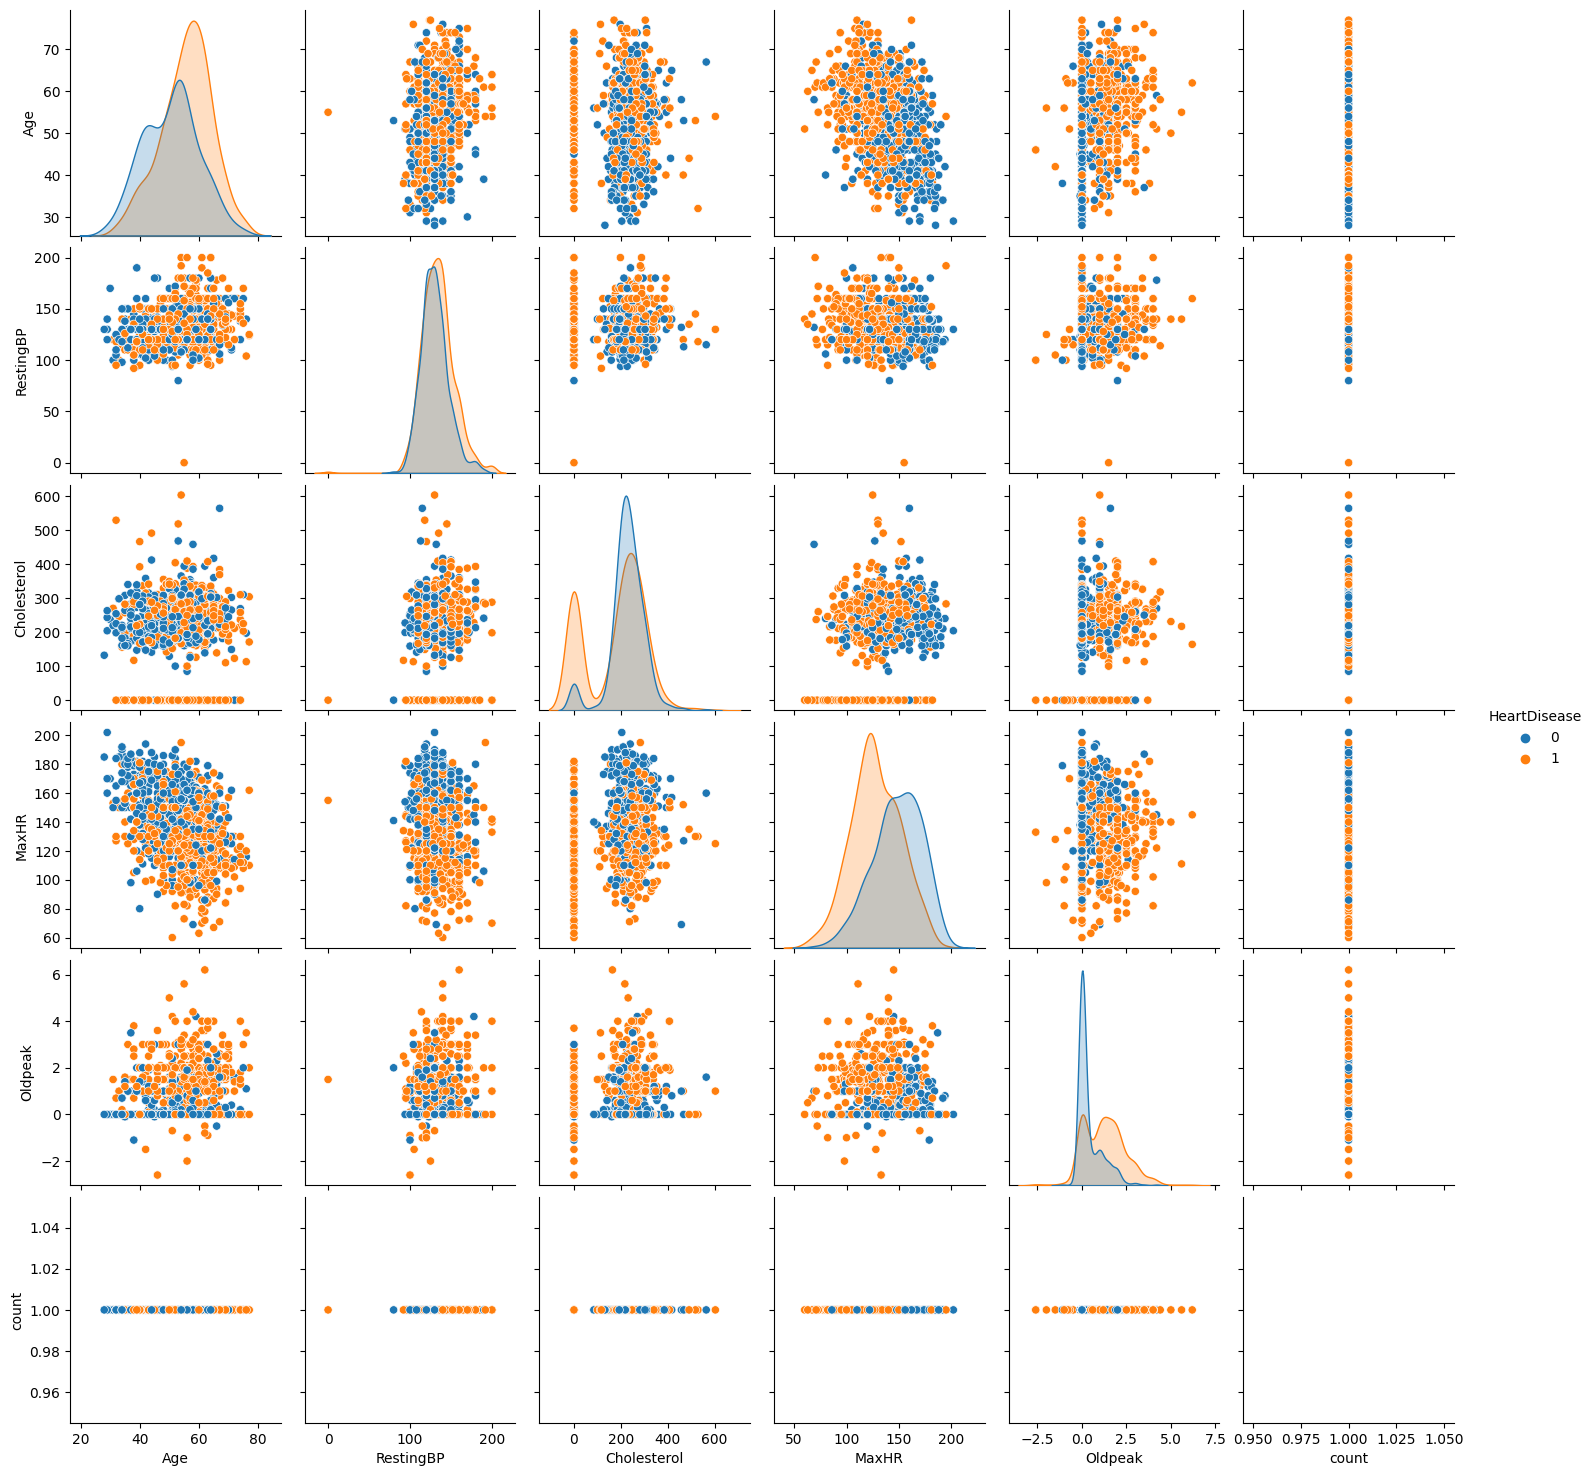

In [15]:
sns.pairplot(df,hue='HeartDisease')

In [174]:
# Determine CSV, label, and key columns
CSV_COLUMNS = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']

LABEL_COLUMN = "HeartDisease"

NUMERICAL_COLUMNS = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
CATEGORICAL_COLUMNS = ['Sex','ChestPainType', 'FastingBS','RestingECG','ExerciseAngina','ST_Slope']

# Set default values for each CSV column.
# Treat is_male and plurality as strings.
DEFAULTS = [0,['null'],['null'], 0,0,['null'], ['null'], 0, ['null'], 0.0, ['null'], 0, ['null']]

In [175]:
df['count'] = 1

In [176]:
df_cat = df[CATEGORICAL_COLUMNS + [LABEL_COLUMN]+['count']]
df_cat = df_cat.groupby(list(df_cat.columns[:-1])).sum().reset_index()

In [177]:
df_cat

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease,count
0,F,ASY,0,LVH,N,Down,1,2
1,F,ASY,0,LVH,N,Flat,0,5
2,F,ASY,0,LVH,N,Flat,1,4
3,F,ASY,0,LVH,N,Up,0,3
4,F,ASY,0,LVH,N,Up,1,2
...,...,...,...,...,...,...,...,...
201,M,TA,1,Normal,N,Flat,1,1
202,M,TA,1,Normal,N,Up,1,2
203,M,TA,1,Normal,Y,Flat,1,1
204,M,TA,1,ST,N,Down,1,1


In [178]:
def plot_cat(cat):
    sns.barplot(x=cat,y='count',hue='HeartDisease',data=df_cat)

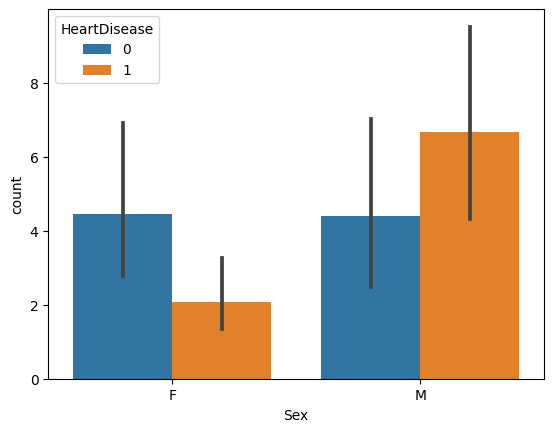

In [299]:
plot_cat(df_cat.columns[0])

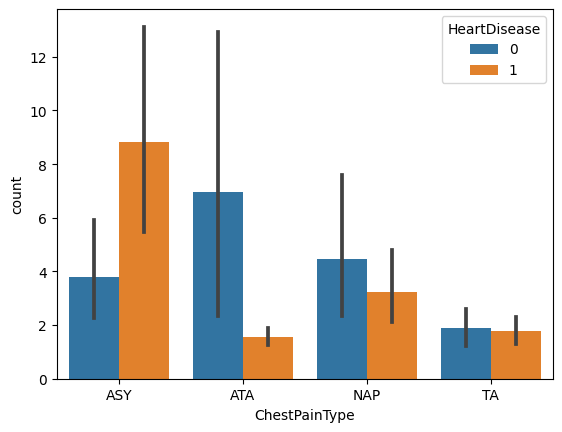

In [298]:
plot_cat(df_cat.columns[1])

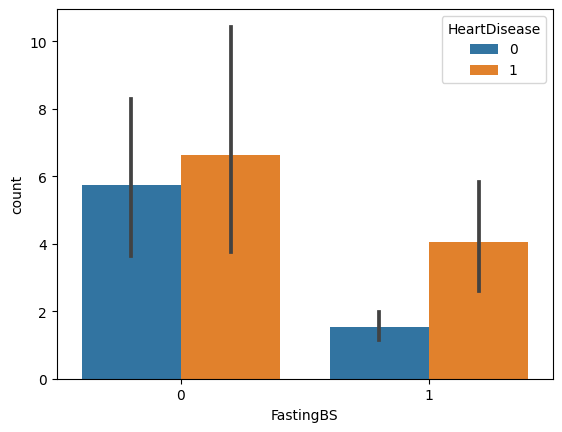

In [27]:
plot_cat(df_cat.columns[2])

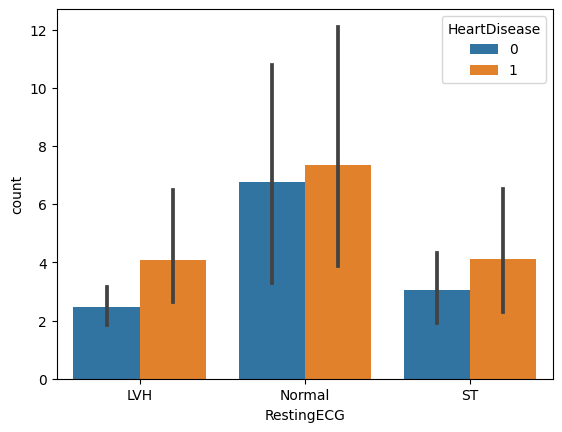

In [28]:
plot_cat(df_cat.columns[3])

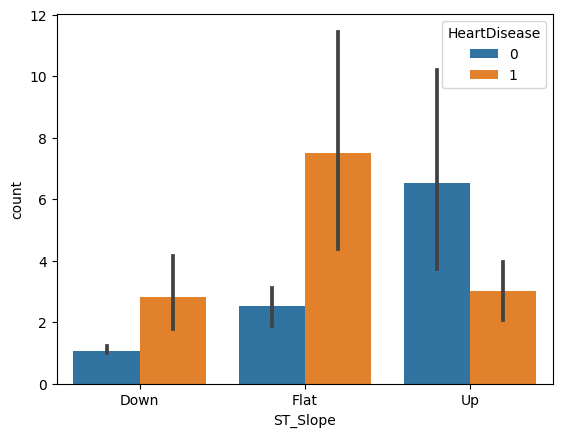

In [29]:
plot_cat(df_cat.columns[5])

In [37]:
df.ST_Slope.value_counts().index

Index(['Flat', 'Up', 'Down'], dtype='object')

<AxesSubplot:xlabel='Age', ylabel='Count'>

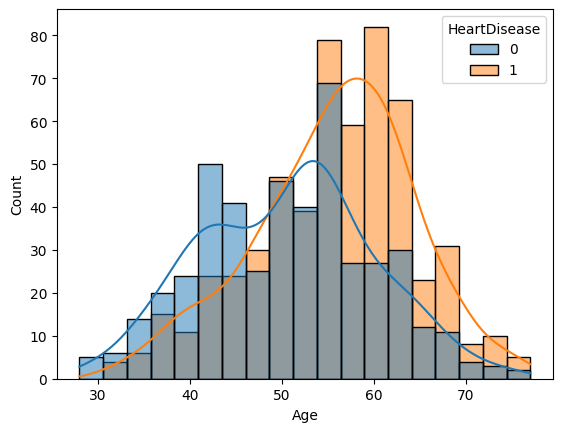

In [30]:
#deciding on binning for age
sns.histplot(data=df,x='Age',hue='HeartDisease',kde=True)

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

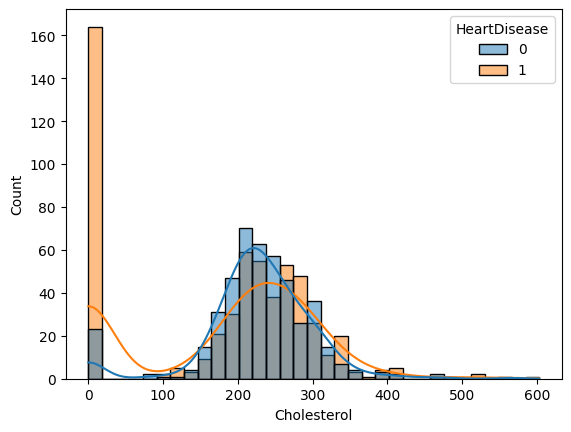

In [31]:
sns.histplot(data=df,x='Cholesterol',hue='HeartDisease',kde=True)

<AxesSubplot:xlabel='MaxHR', ylabel='Count'>

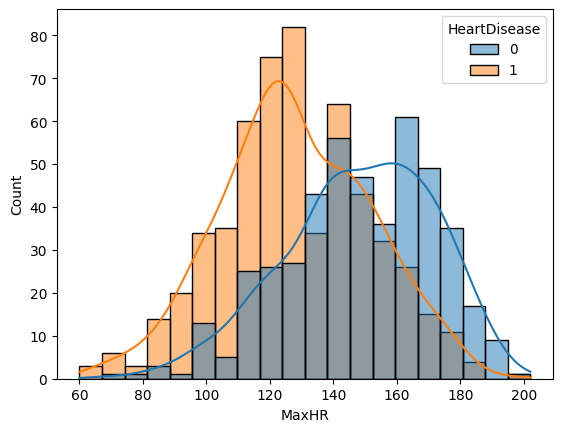

In [32]:
sns.histplot(data=df,x='MaxHR',hue='HeartDisease',kde=True)

<AxesSubplot:xlabel='RestingBP', ylabel='Count'>

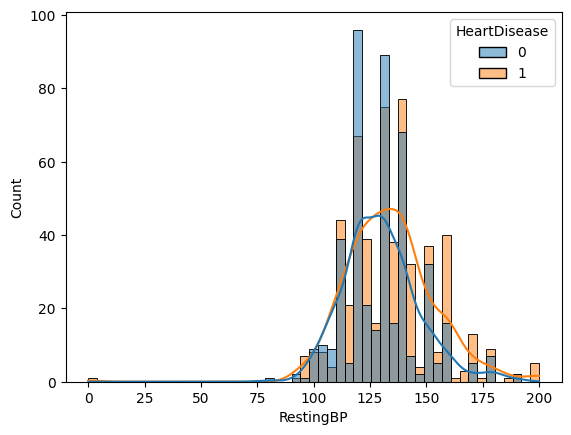

In [33]:
sns.histplot(data=df,x='RestingBP',hue='HeartDisease',kde=True)

In [108]:
num_columns = [i for i in dtypes if dtypes[i] == int]
cat_columns = [i for i in dtypes if dtypes[i] == str]

In [109]:
dtype_map = {int:0,str:['null'],float:0.0}

In [50]:
#[dtype_map[dtypes[i]] for i in dtypes]

In [57]:
#build vocab dict

cat_values = [list(df[col].unique()) for col in df[CATEGORICAL_COLUMNS].columns]

vocab = dict(zip(df[CATEGORICAL_COLUMNS].columns,cat_values))

In [58]:
vocab

{'Sex': ['M', 'F'],
 'ChestPainType': ['ASY', 'ATA', 'NAP', 'TA'],
 'FastingBS': ['0', '1'],
 'RestingECG': ['Normal', 'LVH', 'ST'],
 'ExerciseAngina': ['Y', 'N'],
 'ST_Slope': ['Flat', 'Up', 'Down']}

In [64]:
16**(1/4)

2.0

In [74]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
    )

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=100).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [365]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    deep_inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(1,), dtype="float32"
        )
        for colname in NUMERICAL_COLUMNS
        
        
    }
    
    deep_inputs['ST_Slope'] = tf.keras.layers.Input(name='ST_Slope', shape=(1,), dtype="string")
    deep_inputs['ChestPainType'] = tf.keras.layers.Input(name='ChestPainType', shape=(1,), dtype="string")
   
    


    wide_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(1,), dtype="string")
        for colname in CATEGORICAL_COLUMNS
    }

    inputs = {**wide_inputs, **deep_inputs}

    return inputs

In [366]:
NUMERICAL_COLUMNS.remove('RestingBP')

ValueError: list.remove(x): x not in list

In [367]:
NUMERICAL_COLUMNS

['Age', 'Cholesterol', 'MaxHR']

In [421]:
def transform(inputs, nembeds):
    """Creates dictionary of transformed inputs.

    Returns:
        Dictionary of transformed Tensors
    """
    vocab = {'Sex': ['M', 'F'],
     'ChestPainType': ['ASY', 'ATA', 'NAP', 'TA'],
     'FastingBS': ['0', '1'],
     'RestingECG': ['Normal', 'LVH', 'ST'],
     'ExerciseAngina': ['Y', 'N'],
     'ST_Slope': ['Flat', 'Up', 'Down']}
    
    deep = {}
    wide = {}

    buckets = {
        "Age": np.arange(20,80,10).tolist(),
        "Cholesterol": np.arange(100, 350, 50).tolist(),
        "MaxHR": np.arange(0, 200, 20).tolist(),
        "RestingBP": np.arange(0, 200, 50).tolist()
        
    }
    
    bucketized = {}

    for numeric_column in NUMERICAL_COLUMNS:
        deep[numeric_column] = inputs[numeric_column]
        bucketized[numeric_column] = tf.keras.layers.Discretization(
            buckets[numeric_column]
        )(inputs[numeric_column])
        wide[f"btk_{numeric_column}"] = tf.keras.layers.CategoryEncoding(
            num_tokens=len(buckets[numeric_column]) + 1, output_mode="one_hot"
        )(bucketized[numeric_column])

    crossed_age_chol = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(buckets["Age"]) * len(buckets["Cholesterol"])
    )((bucketized["Age"], bucketized["Cholesterol"]))
    
    crossed_age_MaxHR = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(buckets["Age"]) * len(buckets["MaxHR"])
    )((bucketized["Age"], bucketized["MaxHR"]))

    crossed_age_ST_Slope = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(buckets["Age"]) * len(ST_Slope_vals)
    )((bucketized["Age"], inputs['ST_Slope']))
    
    crossed_ST_Slope_ChestPainType = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(vocab['ST_Slope']) * len(vocab['ChestPainType'])
    )((inputs['ST_Slope'],inputs['ChestPainType']))
    
    
    deep["crossed_age_chol_embed"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=(len(buckets["Age"]) * len(buckets["Cholesterol"])),
            output_dim=nembeds,
        )(crossed_age_chol)
    )

    
    deep["crossed_age_MaxHR_embed"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=(len(buckets["Age"]) * len(buckets["MaxHR"])),
            output_dim=nembeds,
        )(crossed_age_MaxHR)
    )
    
    
    
    deep["crossed_age_ST_Slope_embed"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=(len(buckets["Age"]) * len(ST_Slope_vals)),
            output_dim=nembeds,
        )(crossed_age_ST_Slope)
    )

    deep["crossed_ST_Slope_ChestPainType_embed"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=(len(vocab['ST_Slope']) * len(vocab['ChestPainType'])),
            output_dim=nembeds,
        )(crossed_ST_Slope_ChestPainType)
    )

    
    
    for categorical_column in CATEGORICAL_COLUMNS:
        wide[categorical_column] = tf.keras.layers.StringLookup(
            vocabulary=vocab[categorical_column], output_mode="one_hot"
        )(inputs[categorical_column])

    return wide, deep

In [422]:
def get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units):
    """Creates model architecture and returns outputs.

    Args:
        wide_inputs: Dense tensor used as inputs to wide side of model.
        deep_inputs: Dense tensor used as inputs to deep side of model.
        dnn_hidden_units: List of integers where length is number of hidden
            layers and ith element is the number of neurons at ith layer.
    Returns:
        Dense tensor output from the model.
    """
    # Hidden layers for the deep side
    layers = [int(x) for x in dnn_hidden_units]
    deep = deep_inputs
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(
            units=numnodes, activation="relu", name=f"dnn_{layerno + 1}"
        )(deep)
    deep_out = deep

    # Linear model for the wide side
    wide_out = tf.keras.layers.Dense(
        units=20, activation="relu", name="sigmoid"
    )(wide_inputs)

    # Concatenate the two sides
    both = tf.keras.layers.Concatenate(name="both")([deep_out, wide_out])

    # Final output is a sigmoid activation because this is regression
    output = tf.keras.layers.Dense(units=1, activation="sigmoid", name="weight")(
        both
    )

    return output

In [423]:
def build_wide_deep_model(dnn_hidden_units=[64, 32], nembeds=20):
    """Builds wide and deep model using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layers
    inputs = create_input_layers()

    # transform raw features for both wide and deep
    wide, deep = transform(inputs, nembeds)

    # The Functional API in Keras requires: LayerConstructor()(inputs)
    wide_inputs = tf.keras.layers.Concatenate()(wide.values())
    deep_inputs = tf.keras.layers.Concatenate()(deep.values())

    # Get output of model given inputs
    output = get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="BinaryCrossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(from_logits=True)])

    return model


print("Here is our wide and deep architecture so far:\n")
model = build_wide_deep_model()
print(model.summary())

Here is our wide and deep architecture so far:

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Cholesterol (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 MaxHR (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 discretization_161 (Discretiza  (None, 1)           0           ['Age[0][0]']                    
 tion)                                     

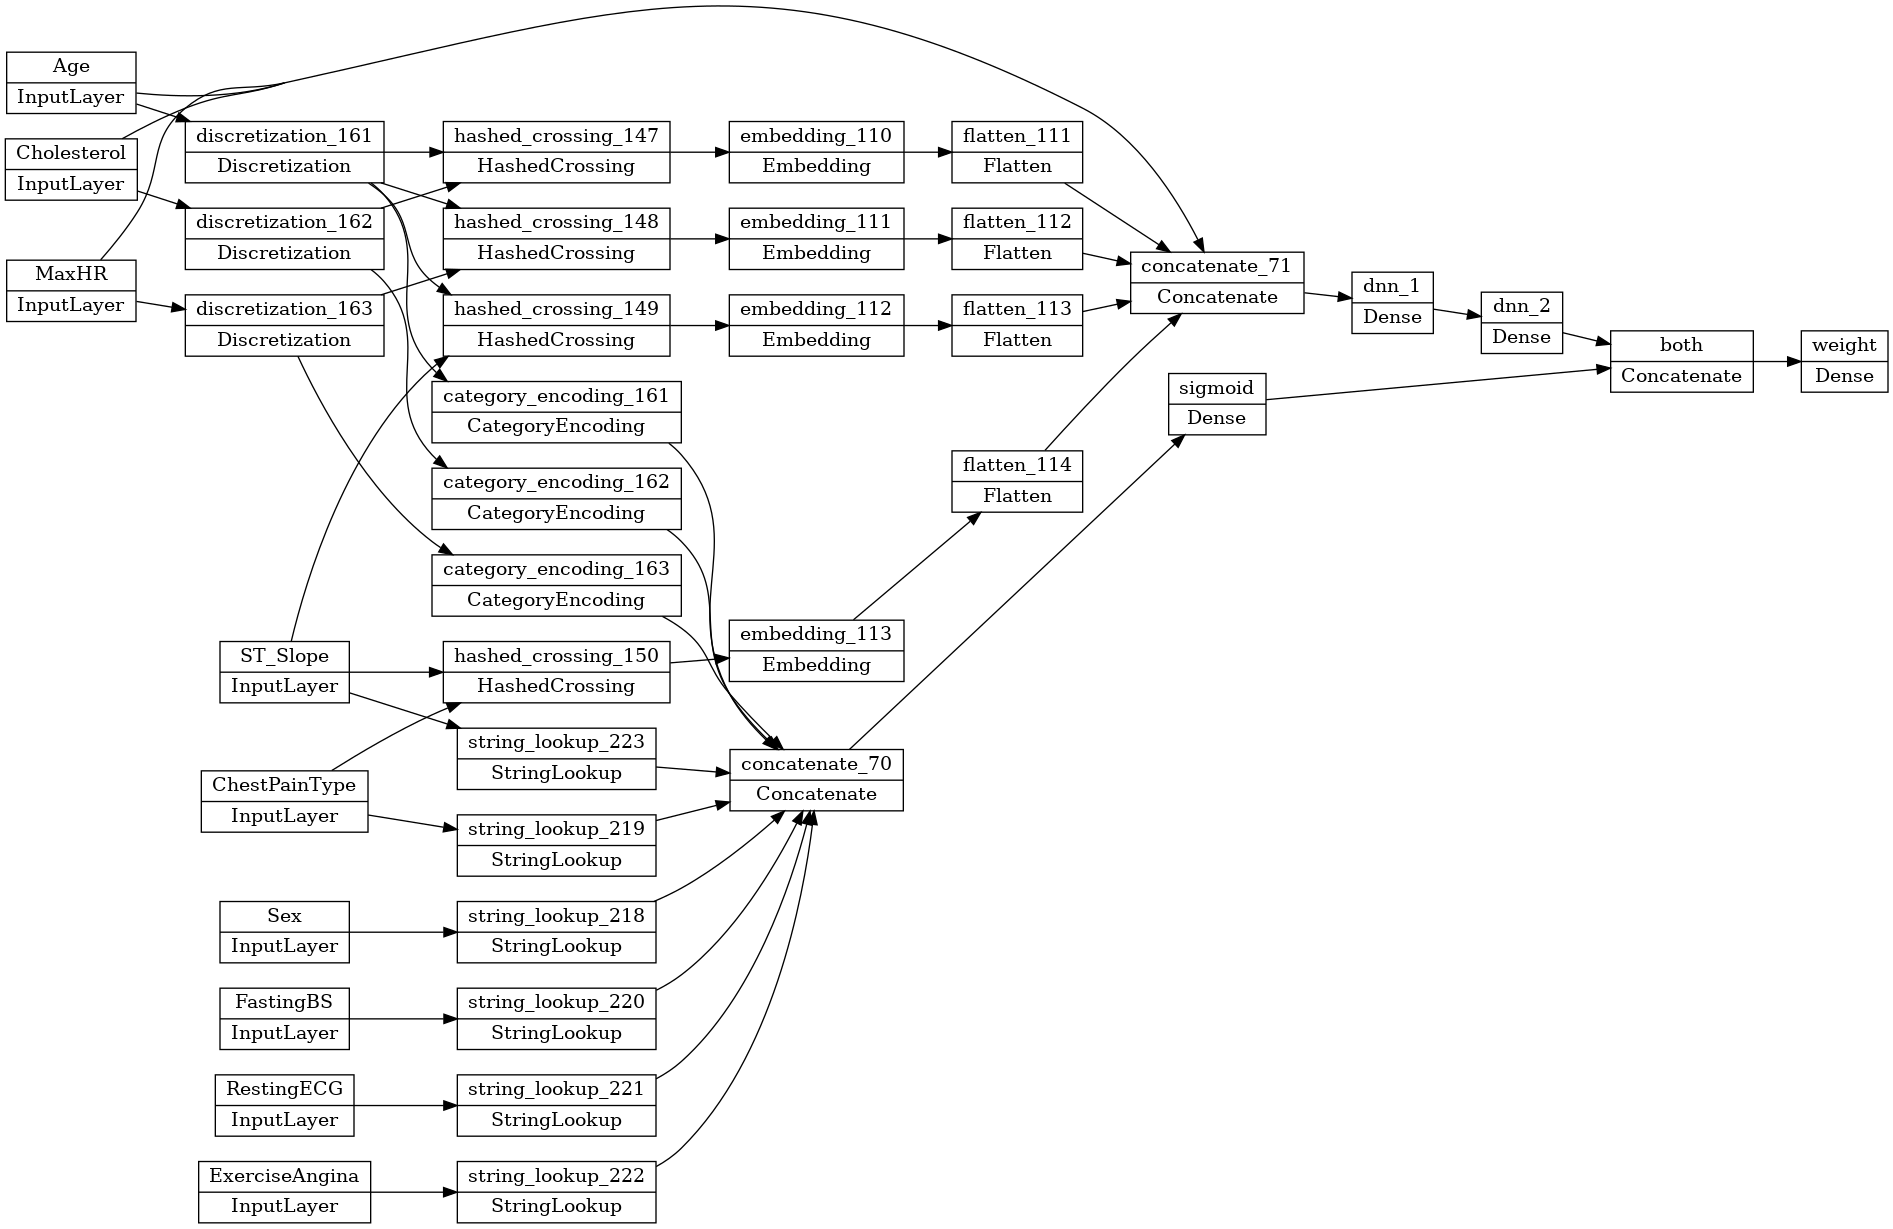

In [424]:
tf.keras.utils.plot_model(
    model=model, to_file="wd_model.png", show_shapes=False, rankdir="LR"
)

In [425]:
TRAIN_BATCH_SIZE = 50
NUM_TRAIN_EXAMPLES = 800  # training dataset repeats, it'll wrap around
NUM_EVALS = 30# how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 100

trainds = load_dataset(
    pattern="/home/jupyter/heart-failure/scaled-heart-train.csv",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

evalds = load_dataset(
    pattern="/home/jupyter/heart-failure/scaled-heart-test.csv", batch_size=100, mode=tf.estimator.ModeKeys.EVAL
).take(count=NUM_EVAL_EXAMPLES // 10)

steps_per_epoch = 100 #NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1
)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback],
)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['RestingBP', 'Oldpeak'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


100/100 [==============================] - 2s 8ms/step - loss: 0.7275 - binary_accuracy: 0.7152 - auc_15: 0.7431 - val_loss: 0.5096 - val_binary_accuracy: 0.7090 - val_auc_15: 0.8210
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3783 - binary_accuracy: 0.8484 - auc_15: 0.9130 - val_loss: 0.4572 - val_binary_accuracy: 0.7640 - val_auc_15: 0.8855
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3250 - binary_accuracy: 0.8782 - auc_15: 0.9319 - val_loss: 0.4258 - val_binary_accuracy: 0.8600 - val_auc_15: 0.8722
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2967 - binary_accuracy: 0.8792 - auc_15: 0.9450 - val_loss: 0.4256 - val_binary_accuracy: 0.8290 - val_auc_15: 0.8968
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2884 - binary_accuracy: 0.8822 - auc_15: 0.9469 - val_loss: 0.4270 - val_binary_accuracy: 0.8570 - val_auc_15: 0.8890
Epoch 6/30
100/100 [=====================

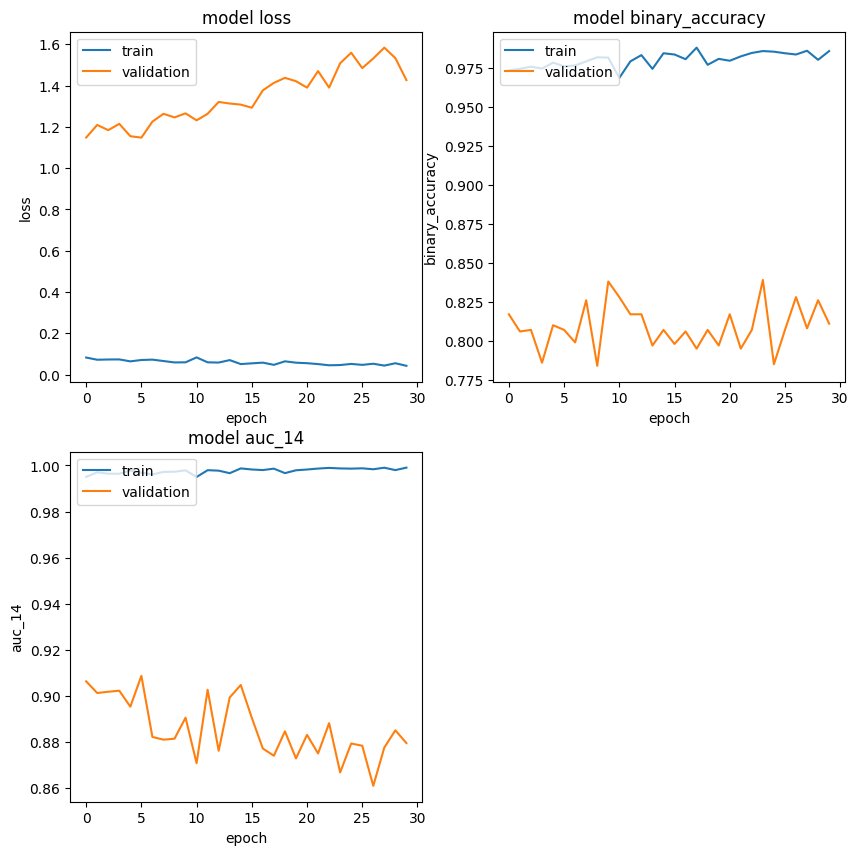

In [420]:
# Plot
nrows = 2
ncols = 2
fig = plt.figure(figsize=(10, 10))

for idx, key in enumerate(["loss","binary_accuracy","auc_14"]):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    plt.plot(history.history[key])
    plt.plot(history.history[f"val_{key}"])
    plt.title(f"model {key}")
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

In [273]:
pd.read_csv(r'/home/jupyter/heart-failure/scaled-heart-train.csv').HeartDisease.value_counts()

1    449
0    382
Name: HeartDisease, dtype: int64

In [274]:
pd.read_csv(r'/home/jupyter/heart-failure/scaled-heart-test.csv').HeartDisease.value_counts()

1    53
0    40
Name: HeartDisease, dtype: int64

In [275]:
pd.read_csv(r'/home/jupyter/heart-failure/scaled-heart-val.csv').HeartDisease.value_counts()

1    60
0    34
Name: HeartDisease, dtype: int64